In [1]:
# Training EfficientNet-B0 pytroch model for image classification 
# Paper: https://arxiv.org/pdf/1905.11946v5.pdf 

# Author: Pradeep Sakhamoori
# Model training: EfficeientNet
# Data: March 29th 2022
# Version: 1.0

In [2]:
import torch
import torch.nn as nn
import os, shutil

import numpy as np

from math import ceil


In [3]:
# DataSet: Access, Split, and labels
TRAIN_RATIO = 0.8

root_dir = 'dataset'
data_dir = os.path.join(os.getcwd(), '../', root_dir, 'SG')
print("data_Dir = ", data_dir)
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for label in classes:
    
    class_dir = os.path.join(images_dir, label)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, label), exist_ok = True)
    os.makedirs(os.path.join(test_dir, label), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, label, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, label, image) 
        shutil.copyfile(image_src, image_dst)

data_Dir =  /home/psakamoori/MyFolder/AiGrandChallenge/AIGC_LandContamination_Dataset1/fault_classification/train/../dataset/SG


In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Reading Train dataset

train_data = datasets.ImageFolder(root = train_dir, transform=transforms.ToTensor())


means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4982, 0.4982, 0.4982])
Calculated stds: tensor([0.2862, 0.2862, 0.2862])


In [5]:
input_size = 300
mean_val = means
std_val = stds

train_tf = transforms.Compose([
                           transforms.Resize(input_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean_val, 
                                                std = std_val)
                       ])

test_tf = transforms.Compose([
                           transforms.Resize(input_size),
                           transforms.CenterCrop(input_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean_val, 
                                                std = std_val)
                       ])


train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_tf)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_tf)

In [6]:
import torch.utils.data as data
import copy
import matplotlib.pyplot as plt

# Validation Data

val_ratio = 0.9

n_train_samples = int(len(train_data) * val_ratio)
n_valid_samples = len(train_data) - n_train_samples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_samples, n_valid_samples])


# Overwrite validation transforms
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_tf

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4248
Number of validation examples: 472
Number of testing examples: 1183


In [7]:
# Set interations with batch_size 
bs = 64

train_loader = data.DataLoader(train_data, shuffle = True, batch_size = bs)
valid_loader = data.DataLoader(valid_data, batch_size = bs)
test_loader = data.DataLoader(test_data, batch_size = bs)

In [9]:
# test block
#for data in train_loader:
#    print("Data: ", len(data))
    #print("Sample rate: {}\nLabels: {}".format(data[0], data[1]))
#    break

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [11]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

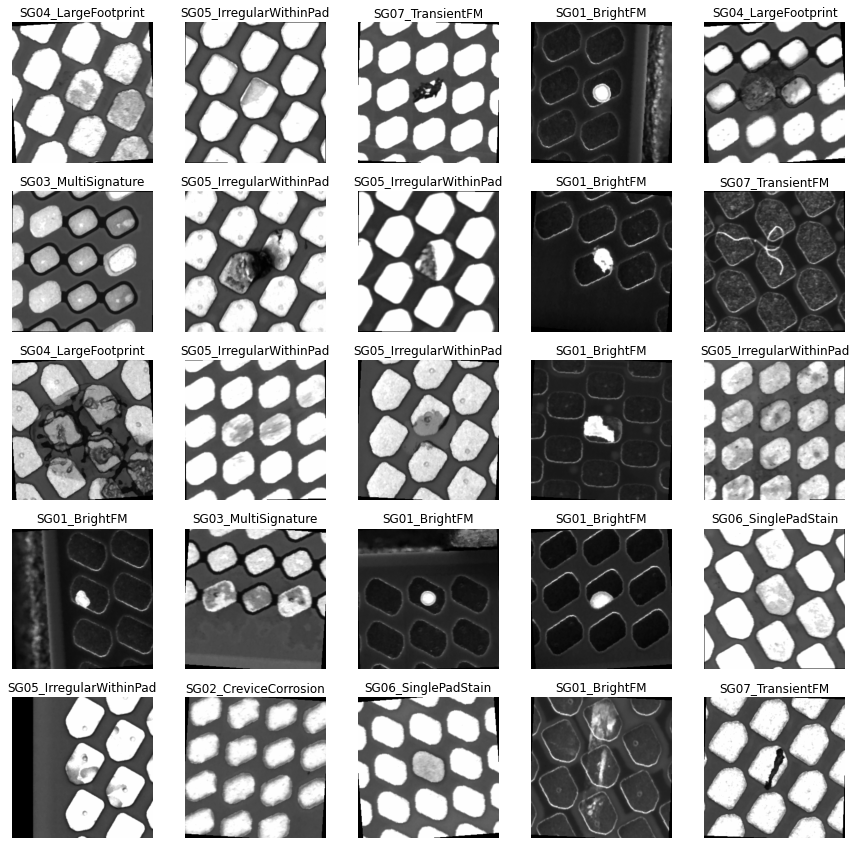

In [12]:
samples = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(samples)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [13]:
# Base Model 
# expand_ratio, channels, repeats, stride, kernel_size 
base_model = [ 
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
] 

In [14]:
# phi values dictionary
# Alpha (depth), Beta (width), gamma (resolution), depth = alpha ^ phi
phi_values = {
    # tuple of: (phi_value, resoltuion, drop_rate)
    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5)
}

In [15]:
class CNNBlock(nn.Module):
    
    # groups - Depthwise convolution (no.of.channels)
    # For normal conv groups=1
    # for DepthWise Conv groups=in_channels
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
        in_channels, 
        out_channels,
        kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        #SiLU same as Swish
        self.silu = nn.SiLU() 
        
    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

In [16]:
# To Calculate attention scores for each of the channel
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> c x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.se(x)

In [17]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, 
                in_channels, 
                out_channels,
                kernel_size,
                stride,
                padding,
                expand_ratio,
                reduction=4, # Squeeze excitation
                survival_prob=0.8, # for stochastic depth
                ): 
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)
        
        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, 
                hidden_dim, 
                kernel_size=3,
                stride=1,
                padding=1
            )
        self.conv = nn.Sequential(
                CNNBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
                SqueezeExcitation(hidden_dim, reduced_dim), 
                nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def stochastic_depth(self, x):
        if not self.training:
            return x
            
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor
        
    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs
            
        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


In [18]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor) # Last channel as per the paper
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes)
        )
                
        
    # Alpha = for depth scaling (no.of.channels)
    # Beta = for width scaling (no.of.layers)
    # as we increase the model size
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        
        # depth factor how many times layers to increase 
        depth_factor = alpha ** phi
        
        # no.of.channels increase
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels
        
        # Reduction factor is set to 4
        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)
            
            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels, 
                        out_channels,
                        expand_ratio = expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size = kernel_size,
                        padding = kernel_size//2, # if k=1, pad=0; k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels
        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )
        
        return nn.Sequential(*features)
    
    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

model = EfficientNet("b0", 9)

In [19]:
# Model training
import torch.optim as optim

def train_model(model, train_loader, n_epochs=1, lr=0.003, device=None):
    
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    criterion = nn.CrossEntropyLoss().to(device)
    loss_history = []
    cnt = 0
    
    for e in range(epochs):
        cnt = 0
        curr_epoch_loss = []
        for idx, (images, target) in enumerate(train_loader):
            images = images.to(device)
            target = target.to(device)
            output = model(images)
            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            curr_epoch_loss.append(loss.cpu().data.numpy())
            print("\rImage processed = ", cnt)
            cnt += 1
        print(f"epoch{e}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        loss_history += curr_epoch_loss
    return model, loss_history

def eval_model(model, dataloader, device=None):
    model.eval()
    pred_all = []
    test_target = []
    
    for idx, (images, target) in enumerate(dataloader):
        images = images.to(device)
        target = target.to(device)
        pred_output = model(images)
        pred_all.append(pred_output)
        test_target.append(target)
    
    pred_all = np.concatenate(pred_all, axis=0)
    test_target = np.concatenate(test_target, axis=0)
        
    return pred_all, test_target
        


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learn_rate = 0.003
epochs = 1
model = model.to(device)

model, loss_history = train_model(model, train_loader, n_epochs=epochs, lr=learn_rate, device=device)

def evaluate_prediction(truth, pred):
    from sklearn.metric import roc_acu_score, f1_score
    
    auroc=roc_auc_score(truth, pred)
    f1 = f1_score(truth, pred > 0.5)
    
    return auroc, f1

In [ ]:
pred, truth = eval_model(model, test_loader, device=device)
auroc, f1 = evaluate_prediction(truth, pred)
print(f"AUROC={auroc} and F1={f1}")